In [ ]:
import cv2
import os
import tensorflow as tf
import numpy as np
from google.colab import drive
import smtplib, ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import random



In [ ]:
# from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/fruit/')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


****************************************************
/content/gdrive/My Drive/fruit/color_image.png
BGR values: 
185.08156737305077 198.8353325336532 201.0169932027189
HSV values
[[[ 24  20 201]]]
check for full fn
500 500 3
height filled:  340
std_height :  400.0
amount of bottle filled:  85.0
****************************************************
/content/gdrive/My Drive/fruit/juice_color.jpg
BGR values: 
7.053104575163399 130.77287581699346 239.1846405228758
HSV values
[[[ 16 248 239]]]
check for full fn
275 183 3
height filled:  80
std_height :  220.0
amount of bottle filled:  36.36363636363637
Bottle empty, Skip it 
Groceries  juice


  0%|          | 0/381 [00:00<?, ?it/s]

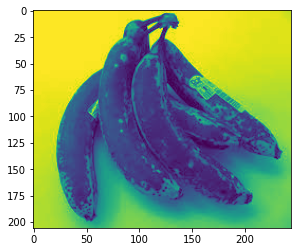

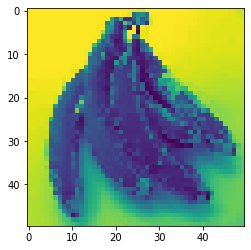

[[1.]]
rotten
Content-Type: multipart/alternative; boundary="===============3127208320016727941=="
MIME-Version: 1.0
Subject: Your Grocery List
From: suryapraveen23@gmail.com
To: sadivi@students.kennesaw.edu

--===============3127208320016727941==
Content-Type: text/plain; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit

  Hi,
  How are you?
  It was quite a busy day it seems. I have few items that you need to purchase for our home. Its time for groceries shopping!!
  here is your list: juice, rotten bananas
--===============3127208320016727941==--

Content-Type: multipart/alternative; boundary="===============9175977349930743234=="
MIME-Version: 1.0
Subject: Your Grocery List
From: suryapraveen23@gmail.com
To: jmhatre1@students.kennesaw.edu

--===============9175977349930743234==
Content-Type: text/plain; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit

  Hi,
  How are you?
  It was quite a busy day it seems. I have few items that you need to 

  0%|          | 0/381 [00:03<?, ?it/s]


In [ ]:
# Code to check the quality and quantity of the item
#  and send email alert of groceries list to be purchased by the end user

body=""
sender_email = "abc@gmail.com"
password = 'xyzy'

def sendEmailTo(glist, receiver_email):
  
  message = MIMEMultipart("alternative")
  message["Subject"] = "Your Grocery List"
  message["From"] = sender_email
  message["To"] = receiver_email

# Create the plain-text and HTML version of your message
  text = """\
  Hi,
  How are you?
  It was quite a busy day it seems. I have few items that you need to purchase for our home. Its time for groceries shopping!!
  here is your list: """+glist

  # Turn these into plain/html MIMEText objects
  part1 = MIMEText(text, "plain")
  # print(glist)
  # part2 = MIMEText(glist,  'plain')

  # Add HTML/plain-text parts to MIMEMultipart message
  # The email client will try to render the last part first
  message.attach(part1)
  # message.attach(part2)
  print (message)
  # Create secure connection with server and send email
  context = ssl.create_default_context()
  with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
      server.login(sender_email, password)
      server.sendmail(
          sender_email, receiver_email, message.as_string()
      )


# --------------------------------------------------------------------
# import cv2
# import numpy as np


T_R = -1
T_B = -1
T_G = -1
E_T_R = -1
E_T_B = -1
E_T_G = -1
apr_r = -1
apr_b = -1
apr_g = -1
hsv = -1
lower = []
upper = []
std_height = 1800
def draw_line(canny_edges, img):
    
    lines = cv2.HoughLines(canny_edges,1,np.pi/180,100)
    min_l = np.pi/2 - 0.005
    max_l = np.pi/2 + 0.005
    print(lines.shape)
    for line in lines:
        rho = line[0][0]
        theta =  line[0][1]
        if theta <= max_l and theta >= min_l:
            
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    return img

def sobel_x(img):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    cv2.imshow("img_x", sobelx)
    return sobelx



def dilate_image(img):
    kernel = np.ones((3,3),np.uint8)
    dilate = cv2.dilate(img,kernel,iterations = 1)
    return dilate

def crop_bottle(image):
    #sobelx = cv2.Sobel(image,cv2.CV_64F, 1, 0, ksize = 1)
    #sobely = cv2.Sobel(image,cv2.CV_64F, 0, 1, ksize = 1)
    cv2.imshow("laplacian", image)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    canny_edges = cv2.Canny(image, 0, 200)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(laplacian,kernel,iterations = 1)
    dilation = np.uint8(dilation)
    #canny_edges = cv2.Canny(dilation, 10, 100)
    cv2.imshow("laplacian", laplacian)
    #opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    contours, hierarchy = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    new_contours = []
    (h, w) = image.shape
    img = cv2.imread("bottle5.jpg")
    for contour in contours:
        if cv2.contourArea(contour)>h*w/20:
            new_contours.append(contour)
    
    cv2.drawContours(img, new_contours, -1, (0,0,255), 3)
    print(len(new_contours))
    cv2.imshow("contours for bottle ",img)
    cv2.waitKey()
    cv2.imshow("contours for bottle ",image)
    

def find_color_space(img):
    img = cv2.imread(img)
    b, g, r = cv2.split(img)
    b = np.mean(b)
    g = np.mean(g)
    r = np.mean(r)
    print("BGR values: ")
    print(b, g, r)
    li_color = np.uint8([[[b,g,r ]]])
    hsv = cv2.cvtColor(li_color,cv2.COLOR_BGR2HSV)
    print("HSV values")
    print(hsv)
    return hsv


def crop_bottle_vvt(image_name):
    image = cv2.imread(image_name,0)
    
    #laplacian = cv2.Laplacian(image, cv2.CV_64F)
    canny_edges = cv2.Canny(image, 0, 20)
    
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(canny_edges,kernel,iterations = 4)
    dilation = np.uint8(dilation)
    (h, w) = dilation.shape
    print(str(h)+" "+str(w))
    for i in range(w):
        dilation[h-3,i] = 255
        dilation[h-2,i] = 255
        dilation[h-1,i] = 255
        
    cv2.imwrite("dilated.jpg", dilation)
    #canny_edges = cv2.Canny(dilation, 10, 100)
    cv2.imshow("dilated", dilation)
    #opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    contours, hierarchy = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    new_contours = []
    (h, w) = image.shape
    img = cv2.imread(image_name)
    for contour in contours:
        if cv2.contourArea(contour)>h*w/10:
            new_contours.append(contour)
    im2 =  np.zeros((img.shape[0], img.shape[1],3), np.uint8)
    
    cv2.drawContours(img, new_contours, -1, (0,0,255), 3)
    cv2.imwrite("final_image.jpg", img)
    print(len(new_contours))
    return new_contours[0]





def set_intensity_full(img):
    img = cv2.imread(img)
    b, g, r = cv2.split(img)
    T_B = np.mean(b)
    T_G = np.mean(g)
    T_R = np.mean(r)
    return T_B, T_G, T_R


def set_intensity_empty(img):
    img = cv2.imread(img)
    print("inside empty")
    b, g, r = cv2.split(img)
    cv2.imshow("hg", b)
    E_T_B = np.mean(b)
    E_T_G = np.mean(g)
    E_T_R = np.mean(r)
    return  E_T_B, E_T_G, E_T_R

def set_apr_values():
    apr_r = abs(E_T_R - T_R)/2
    apr_b = abs(E_T_B - T_B)/2
    apr_g = abs(E_T_G - T_G)/2
    return apr_b, apr_g, apr_r


    
def level_detection(img, contour):
    
    if(apr_r == -1 or apr_g == -1 or apr_b == -1):
        print("First set the values of the threshold")
        return
    
    img = cv2.imread(img)
    x, y, w, h = cv2.boundingRect(contour)
    cv2.imshow("final contour", cv2.drawContours(img, contour, -1, (0,0,255), 3))
    count_liquid = 0
    count_empty = 0
    total_pixel = 0
    print(x, y, w, h)
    
    for i in range(y, y+h):
        for j in range(x, x+w):
             if cv2.pointPolygonTest(contour, (i, j), False) >0 :
                total_pixel = total_pixel + 1           
                if abs(img[i][j][0]-T_B) <= apr_b and abs(img[i][j][0]-T_B) <= apr_b and abs(img[i][j][0]-T_B) <= apr_b:
                    count_liquid = count_liquid+1
                if abs(img[i][j][0]-E_T_B) <= apr_b and abs(img[i][j][0]-E_T_B) <= apr_b and abs(img[i][j][0]-E_T_B) <= apr_b:
                    count_empty = count_empty+1
    
    res = count_liquid/(count_liquid + count_empty)
    print(count_liquid,count_empty, res)
    return res



#if cv2.pointPolygonTest(contour, (i, j), False) >0 :
                #total_pixel = total_pixel + 1
            
# read the image
def main_function_old():
    global E_T_R, E_T_B, E_T_G
    global T_R, T_B, T_G
    global apr_r, apr_b, apr_g
    
    if E_T_R == -1 or E_T_B == -1 or  E_T_G == -1:
        print("caliberate empty bottle name of the image:")
        image_name = input()
        E_T_R, E_T_B, E_T_G = set_intensity_empty(image_name)
        print("Updated parameters: ", E_T_B, E_T_G, E_T_R)
    if T_R == -1 or T_B == -1 or  T_G == -1:
        
        print("caliberate full bottle name of the image:")
        image_name = input()
        T_B, T_G, T_R = set_intensity_full(image_name)
        print("Updated parameters: ", T_B, T_G, T_R)
    if apr_r == -1:
        apr_r, apr_b, apr_g = set_apr_values()
    print(apr_r, apr_g, apr_b)
    
    while True :
        print("do you have next image:(y/n):")
        string = input()
        if string == "n":
            break
        print("image name to detect the level:")
        image_name = input()
        contour = crop_bottle_vvt(image_name)
        level_detection(image_name, contour)

def set_threshold(sample_image):
    print("****************************************************")
    print(sample_image)
    global hsv
    global lower
    global upper
    hsv = find_color_space(sample_image)
    lower = np.array([hsv[0][0][0]-5, hsv[0][0][1]-50, hsv[0][0][2]-50])
    upper = np.array([hsv[0][0][0]+5, hsv[0][0][1]+50, hsv[0][0][2]+50])

def check_for_full(image_name):
    print("check for full fn")
    global std_height
    
    img = cv2.imread(image_name)
    h, w, c = img.shape
    print(h, w, c)
    std_height = h*80/100
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img, lower, upper)
    count = 0
    height = 0;
    for i in range(h):
        for j in  range(w):
            if mask[i][j]>=100:
                count = count+1
            if count>50:
                height = i
                break
        if height != 0 :
            break
    img = cv2.imread(image_name)
    img = cv2.line(img, (0,height), (w,height), (0,0,255),10)
    cv2.imwrite("results.jpg", img)
    if height != 0:
        #print("checking", height)
        height = h-height
    percent = (height/std_height)*100
    print("height filled: ",height)
    print("std_height : ", std_height)
    print("amount of bottle filled: ", percent)
    if percent < 80:
        print("Bottle empty, Skip it ")
        return False;
    else:
        return True
    cv2.imwrite("mask.jpg", mask)
    

# ---------------------------------------------------------

def main_function():
    global hsv
    global body 
    if hsv == -1:
        # print("Enter the color sample of the liquid\n")
        image_name = '/content/gdrive/My Drive/fruit/color_image.png'
        set_threshold(image_name)
        # print("Input the name of the image or to exit type 'n'")
        image = '/content/gdrive/My Drive/fruit/milkbottel.jpg'
        flag =check_for_full(image)
        if not flag:
          body = body + 'milk '
        # image  = '/content/gdrive/My Drive/fruit/milkbottle_half.jpg'
        # flag =check_for_full(image)
        if not flag:
          body = body + 'milk '
        image_name = '/content/gdrive/My Drive/fruit/juice_color.jpg'
        set_threshold(image_name)
        # print("Input the name of the image or to exit type 'n'")
        image = '/content/gdrive/MyDrive/fruit/juice_half.jpg'
        flag=check_for_full(image)
        if not flag:
          body = body + 'juice'
        print('Groceries ',body)
        # sendEmailTo(body, 'jmhatre1@students.kennesaw.edu')
        # sendEmailTo(body, 'sadivi@students.kennesaw.edu')
        # sendEmailTo(body, 'aturlapa@students.kennesaw.edu')
main_function()
# --------------------------------------
DATADIR = 'dataset/test'
CATAGORIES = ["freshbanana","rottenbanana"]
# ------------------------------------------------------------
def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array)
    plt.show()
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array)
    plt.show()

    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("onefruit-cnn.model")

# ----------------------------------------------------------------
# from tqdm import tqdm
# import matplotlib.pyplot as plt
count = 1
path = os.path.join(DATADIR,CATAGORIES[0])
for img in tqdm(os.listdir(path)):   
  
  #prediction = model.predict([prepare(os.path.join(path,img))])
  #test your own image
  prediction = model.predict([prepare('rottenBanana.jpg')])
  print(prediction) 
  if int(prediction[0][0]) == 1:
    print("rotten")
    body = body +", rotten bananas"
    sendEmailTo(body, 'sadivi@students.kennesaw.edu')
    sendEmailTo(body, 'jmhatre1@students.kennesaw.edu')
    sendEmailTo(body, 'aturlapa@students.kennesaw.edu')



  else:
    print("fresh")
    # body ="fresh bananas"
    # sendEmailTo(body, 'suryapraveen23@gmail.com')

  
  break
  



In [ ]:
# Below is the code to evaluate the model Accuracy 

In [ ]:
testing_data = []
IMG_SIZE = 50

CATEGORIES = ["freshbanana","rottenbanana"]
def create_testing_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                testing_data.append([new_array, class_num])
            except Exception as e:
                pass
           
create_testing_data()


random.shuffle(testing_data)
X = []
y = []
for features,label in testing_data:
    X.append(features)
    y.append(label)

# print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# --------------------------------------

pickle_out = open("ATXNS.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("atyns.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# ----------------------------------------------
pickle_in = open("ATXNS.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("atyns.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y)

results = model.evaluate(X, y, batch_size=128)
print('test loss, test acc:', results)
# print(len(testing_data))

100%|██████████| 530/530 [00:04<00:00, 113.84it/s]


8/8 [==============================] - 1s 103ms/step - loss: 0.0418 - accuracy: 0.9846
test loss, test acc: [0.0417579784989357, 0.9846322536468506]
